# Task 1
"Generate adversarial examples in the context of the zero-knowledge threat model."

In [1]:
import os
import sys
from pathlib import Path

In [2]:
# Set up proper directory paths

project_path = Path().absolute().parent
src_path = project_path.joinpath("src")

# Ensure the paths are properly assigned
# If this assertion fails, change project_dir as needed to become the project directory
# If project_dir is correct, change the name in the assertion check
assert project_path.name == "project-athena", "Parent directory name assertion failed (check the path)"

In [3]:
# Add src_dir to module paths
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

In [4]:
import time

import numpy as np

In [5]:
from matplotlib import pyplot as plt

In [6]:
from attacks.attack import generate
from models.athena import ENSEMBLE_STRATEGY, Ensemble
from utils.data import subsampling
from utils.file import load_from_json
from utils.metrics import error_rate, get_corrections
from utils.model import load_lenet, load_pool

In [7]:
def generate_ae(model, data, labels, attack_configs, save=False, output_dir=None, device=None):
    """
    Generate adversarial examples for a model
    """
    
    print("Generating adversarial examples")
    
    num_attacks = attack_configs.get("num_attacks")
    data_loader = (data, labels)
    
    # For plotting
    img_rows, img_cols = data.shape[1], data.shape[2]

    if len(labels.shape) > 1:
        labels = np.asarray([np.argmax(p) for p in labels])

    # Generate attacks
    for attack_id in range(num_attacks):
        key = f"configs{attack_id}"
        
        data_adversarial = generate(model=model,
                                    data_loader=data_loader,
                                    attack_args=attack_configs[key],
                                    device=device)
        
        # Evaluate adversarial examples
        y_pred = model.predict(data_adversarial)
        y_pred = np.asarray([np.argmax(p) for p in y_pred])

        err = error_rate(y_pred=y_pred, y_true=labels)
        
        print(f">>> error rate: {err}")

        # Save adversarial examples
        if save:
            if output_dir is None:
                raise ValueError("Cannot save images to a none path.")
            
            file_path = Path(output_dir).joinpath(f"{attack_configs[key]['attack']}-{time.monotonic()}.npy")
            np.save(file_path, data_adversarial)
            
            print(f"Saved adversarial example to file [{file_path}]")
        
        print((attack_configs[key]['attack']))
        
        batch_size = min(data.shape[0], 2)
        fig = plt.figure(figsize=(1, batch_size), dpi=300)
        
        for i in range(batch_size):
            fig.add_subplot(1, batch_size, i + 1)
            plt.axis("off")
            plt.imshow(data_adversarial[i].reshape((img_rows, img_cols)), cmap='gray')
        
        plt.show()
        
    np.save(Path(output_dir).joinpath("true_labels.npy"), labels)
    
    print("Done generating adversarial examples")

In [8]:
def evaluate(trans_configs, model_configs, data_configs,
             save=False, output_dir=None):
    """
    Apply transformation(s) on images.
    :param trans_configs: dictionary. The collection of the parameterized transformations to test.
        in the form of
        { configsx: {
            param: value,
            }
        }
        The key of a configuration is 'configs'x, where 'x' is the id of corresponding weak defense.
    :param model_configs:  dictionary. Defines model related information.
        Such as, location, the undefended model, the file format, etc.
    :param data_configs: dictionary. Defines data related information.
        Such as, location, the file for the true labels, the file for the benign samples,
        the files for the adversarial examples, etc.
    :param save: boolean. Save the transformed sample or not.
    :param output_dir: path or str. The location to store the transformed samples.
        It cannot be None when save is True.
    :return:
    """
    
    # Load baseline defense (PGD-ADT model)
    baseline = load_lenet(file=model_configs['pgd_trained'],
                          trans_configs=None,
                          use_logits=False,
                          wrap=False)

    # Load undefended model (UM)
    file = project_path.joinpath(model_configs['dir'], model_configs['um_file'])
    undefended = load_lenet(file=file,
                            trans_configs=trans_configs.get('configs0'),
                            wrap=True)
    
    print(f">>> UM: {type(undefended)}")

    # Load weak defenses into a pool
    pool, _ = load_pool(trans_configs=trans_configs,
                        model_configs=model_configs,
                        active_list=True,
                        wrap=True)
    
    # Create an AVEP ensemble from the WD pool
    wds = list(pool.values())
    ensemble = Ensemble(classifiers=wds, strategy=ENSEMBLE_STRATEGY.AVEP.value)
    
    print(f">>> wds: {type(wds)} {type(wds[0])}")

    # Load benign samples
    bs_file = project_path.joinpath(data_configs['dir'], data_configs['bs_file'])
    
    # Hacky workaround for benign data being in different directory as adversarial data
    if 'benign_dir' in data_configs:
        bs_file = project_path.joinpath(data_configs['benign_dir'], data_configs['bs_file'])
    
    x_bs = np.load(bs_file)
    img_rows, img_cols = x_bs.shape[1], x_bs.shape[2]

    # Load true labels
    label_file = project_path.joinpath(data_configs['dir'], data_configs['label_file'])
    labels = np.load(label_file)

    print(f">>> Evaluating UM on [{bs_file}]")
    
    # Get indices of benign samples that are correctly classified by the targeted model
    pred_bs = undefended.predict(x_bs)
    corrections = get_corrections(y_pred=pred_bs, y_true=labels)

    # Evaluate adversarial examples
    results = {}
    
    # Only run on one example
    ae_files = data_configs.get('ae_files')
    ae_file = project_path.joinpath(data_configs['dir'], ae_files[4])
    x_adversarial = np.load(ae_file)
    
    print(f">>> Evaluating UM on [{ae_file}]")

    # Evaluate undefended model on adversarial examples
    pred = undefended.predict(x_adversarial)
    err = error_rate(y_pred=pred, y_true=labels, correct_on_bs=corrections)
    results['UM'] = err
    
    print(f">>> Evaluating ensemble on [{ae_file}]")

    # Evaluate ensemble model on adversarial examples
    pred = ensemble.predict(x_adversarial)
    err = error_rate(y_pred=pred, y_true=labels, correct_on_bs=corrections)
    results['Ensemble'] = err

    # Evaluate baseline model on adversarial examples
    print(f">>> Evaluating baseline model on [{ae_file}], it may take a while...")
    pred = baseline.predict(x_adversarial)
    err = error_rate(y_pred=pred, y_true=labels, correct_on_bs=corrections)
    results['PGD-ADT'] = err

    # TODO: collect and dump the evaluation results to file(s) such that you can analyze them later.
    print(f">>> Evaluations on [{ae_file}]:\n{results}")

In [9]:
def run_task(trans_configs=None, model_configs=None, data_configs=None,
            save=False, output_dir=None):
    attack_configs = src_path.joinpath("configs/demo/attack-zk-mnist.json")
    
    # Load benign samples
    file = project_path.joinpath(data_configs['dir'], data_configs['bs_file'])
    x_benign = np.load(file)
    
    # Load true labels
    file = project_path.joinpath(data_configs['dir'], data_configs['label_file'])
    y_true = np.load(file)
    
    # Load adversarial examples
    ae_files = data_configs.get('ae_files')
    ae_file = project_path.joinpath(data_configs['dir'], ae_files[1])
    x_adversarial = np.load(ae_file)
    
    # Load undefended model (UM)
    file = project_path.joinpath(model_configs['dir'], model_configs['um_file'])
    undefended_model = load_lenet(file=file,
                                  trans_configs=trans_configs.get('configs0'),
                                  wrap=True)
    
    # Load baseline model
    baseline_model = load_lenet(file=model_configs['pgd_trained'],
                                trans_configs=None,
                                use_logits=False,
                                wrap=False)
    
    # Load weak defenses into a pool
    pool, _ = load_pool(trans_configs=trans_configs,
                        model_configs=model_configs,
                        active_list=True,
                        wrap=True)
    
    # Create an AVEP ensemble from the WD pool
    wds = list(pool.values())
    ensemble_model = Ensemble(classifiers=wds, strategy=ENSEMBLE_STRATEGY.AVEP.value)
    
    print(f">>> wds: {type(wds)} {type(wds[0])}")
    
    # Get indices of benign samples that are correctly classified by the targeted model
    pred_bs = undefended.predict(x_bs)
    corrections = get_corrections(y_pred=pred_bs, y_true=labels)
    
    

In [10]:
# Load data configs
file = src_path.joinpath("configs/demo/data-mnist.json")
data_configs = load_from_json(file)
output_path = project_path.joinpath("results")

# Load model configs
model_configs = load_from_json(src_path.joinpath("configs/demo/model-mnist.json"))
attack_configs = load_from_json(src_path.joinpath("configs/demo/attack-zk-mnist.json"))

# Fix configs
# i.e. remove relative paths
data_configs['dir'] = str(project_path.joinpath("data"))
data_configs['sub_dir'] = str(project_path.joinpath("results"))

model_configs['dir'] = str(project_path.joinpath("models/cnn"))
model_configs['pgd_trained'] = str(project_path.joinpath("models/baseline", Path(model_configs['pgd_trained']).name))

In [11]:
# Load benign samples
file = project_path.joinpath(data_configs['dir'], data_configs['bs_file'])
X_bs = np.load(file)

In [12]:
# Load true labels
file =  project_path.joinpath(data_configs['dir'], data_configs['label_file'])
labels = np.load(file)

In [13]:
# Load model
model_file = project_path.joinpath(model_configs['dir'], model_configs['um_file'])
target = load_lenet(file=model_file, wrap=True)

>>> Loading model [D:\GitHub\project-athena\models\cnn\model-mnist-cnn-clean.h5]...


In [14]:
# Load the benign samples
# TODO: Is this redundant duplicate code?
data_file = project_path.joinpath(data_configs['dir'], data_configs['bs_file'])
data_bs = np.load(data_file)

In [15]:
# Load true labels
label_file = project_path.joinpath(data_configs['dir'], data_configs['label_file'])
labels = np.load(label_file)

In [16]:
# Clear results folder
result_files = os.listdir(project_path.joinpath("results"))

for f in result_files:
    os.remove(project_path.joinpath("results", f))

print("Cleared results folder")

Cleared results folder


Generating adversarial examples
>>> Generating FGSM examples.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
>>> error rate: 0.018
Saved adversarial example to file [D:\GitHub\project-athena\results\fgsm-187886.64.npy]
fgsm


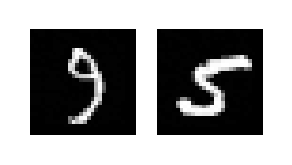

>>> Generating FGSM examples.
>>> error rate: 0.082
Saved adversarial example to file [D:\GitHub\project-athena\results\fgsm-187889.875.npy]
fgsm


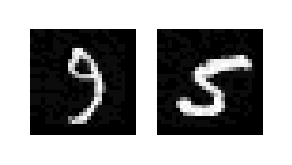

>>> Generating FGSM examples.
>>> error rate: 0.242
Saved adversarial example to file [D:\GitHub\project-athena\results\fgsm-187892.859.npy]
fgsm


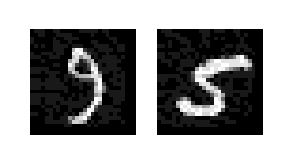

>>> Generating FGSM examples.
>>> error rate: 0.742
Saved adversarial example to file [D:\GitHub\project-athena\results\fgsm-187896.031.npy]
fgsm


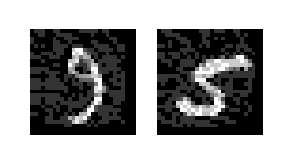

>>> error rate: 0.124
Saved adversarial example to file [D:\GitHub\project-athena\results\pgd-187909.625.npy]
pgd


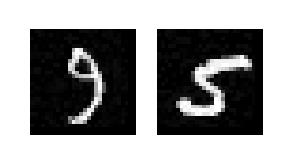

>>> error rate: 0.996
Saved adversarial example to file [D:\GitHub\project-athena\results\pgd-187923.437.npy]
pgd


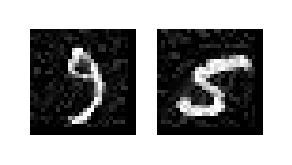

>>> error rate: 1.0
Saved adversarial example to file [D:\GitHub\project-athena\results\pgd-187937.515.npy]
pgd


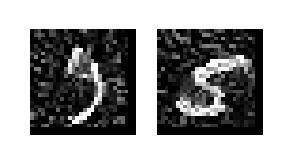

>>> error rate: 1.0
Saved adversarial example to file [D:\GitHub\project-athena\results\pgd-187951.687.npy]
pgd


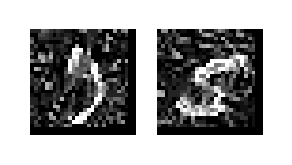

>>> error rate: 0.86
Saved adversarial example to file [D:\GitHub\project-athena\results\bim-187978.156.npy]
bim


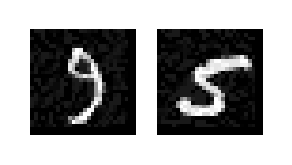

>>> error rate: 0.86
Saved adversarial example to file [D:\GitHub\project-athena\results\bim-188003.937.npy]
bim


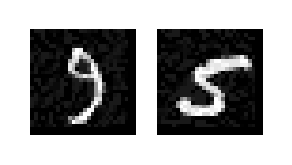

>>> error rate: 0.904
Saved adversarial example to file [D:\GitHub\project-athena\results\bim-188042.406.npy]
bim


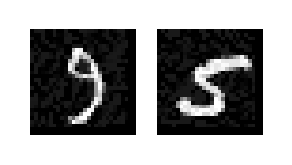

>>> error rate: 0.908
Saved adversarial example to file [D:\GitHub\project-athena\results\bim-188092.234.npy]
bim


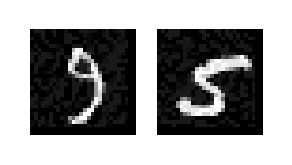

>>> error rate: 1.0
Saved adversarial example to file [D:\GitHub\project-athena\results\bim-188142.046.npy]
bim


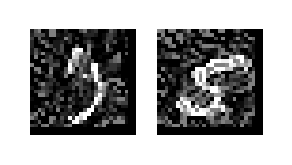

Done generating adversarial examples


In [17]:
# Generate adversarial examples
#data_bs = data_bs[:5]
#labels = labels[:5]

generate_ae(model=target, data=data_bs,labels=labels, attack_configs=attack_configs,
            save=True, output_dir=output_path)

In [18]:
# Replace adversarial examples with results files
data_configs['dir'] = str(project_path.joinpath("results"))
data_configs['benign_dir'] = str(project_path.joinpath("data"))
data_configs['ae_files'] = os.listdir(project_path.joinpath("results"))
data_configs['label_file'] = str(project_path.joinpath("results", "true_labels.npy"))

In [19]:
# Load configs
file = src_path.joinpath("configs/demo/athena-mnist.json")
trans_configs = load_from_json(file)

output_dir = project_path.joinpath("results")
output_dir.mkdir(exist_ok=True)

# Evaluate model
evaluate(trans_configs=trans_configs,
         model_configs=model_configs,
         data_configs=data_configs,
         save=False,
         output_dir=output_dir)

>>> Loading model [D:\GitHub\project-athena\models\baseline\advTrained-mnist-adtC.h5]...
>>> Loading model [D:\GitHub\project-athena\models\cnn\model-mnist-cnn-clean.h5]...
>>> UM: <class 'models.keras.WeakDefense'>
>>> Loading model [D:\GitHub\project-athena\models\cnn\model-mnist-cnn-flip_horizontal.h5]...
>>> Loading model [D:\GitHub\project-athena\models\cnn\model-mnist-cnn-affine_both_stretch.h5]...
>>> Loading model [D:\GitHub\project-athena\models\cnn\model-mnist-cnn-morph_gradient.h5]...
>>> Loaded 3 models.
>>> wds: <class 'list'> <class 'models.keras.WeakDefense'>
>>> Evaluating UM on [D:\GitHub\project-athena\data\subsamples-mnist-ratio_0.05-285857.296.npy]
>>> Evaluating UM on [D:\GitHub\project-athena\results\bim-188142.046.npy]
>>> Evaluating ensemble on [D:\GitHub\project-athena\results\bim-188142.046.npy]
>>> Evaluating baseline model on [D:\GitHub\project-athena\results\bim-188142.046.npy], it may take a while...
>>> Evaluations on [D:\GitHub\project-athena\results\bim